<details>
<summary>Table of Contents</summary>

- [1. Naive/ persistence forecast](#1-naive-persistence-forecast)
- [2. S(ARIMA)](#2-sarima)

</details>



Script with naive forecast and (S)ARIMA.

In [1]:
import os
import numpy as np 
import pandas as pd
import time 

import matplotlib.pyplot as plt
from pmdarima import auto_arima
from utils.helper import split_scale_dataset, running_time

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load data
combined_df = pd.read_csv("datasets/combined_data.csv", index_col=0, parse_dates=True)

Split and scale datasets.

In [3]:
train, vali, test = split_scale_dataset(combined_df, train_split=0.7, test_split=0.15, scaler_type='minmax')

29136 observations in the train dataset.
6240 observations in the validation dataset. 
6240 observations in the test dataset.


In [4]:
train.describe().round(2)

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual
count,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00,29136.00
mean,0.54,0.14,0.26,0.33,0.24,0.61,0.13,0.33,0.31,0.31,0.47,0.24,0.32,0.38,0.16,0.20,0.46,0.20,0.30
std,0.22,0.22,0.20,0.24,0.20,0.14,0.20,0.21,0.21,0.20,0.20,0.29,0.19,0.19,0.22,0.18,0.21,0.28,0.22
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.36,0.00,0.10,0.11,0.09,0.50,0.00,0.16,0.13,0.15,0.30,0.01,0.17,0.24,0.00,0.08,0.28,0.00,0.12
50%,0.54,0.00,0.20,0.30,0.18,0.63,0.01,0.29,0.27,0.28,0.48,0.10,0.29,0.35,0.02,0.15,0.45,0.01,0.25
75%,0.74,0.22,0.36,0.51,0.33,0.71,0.21,0.48,0.47,0.46,0.63,0.44,0.43,0.51,0.30,0.27,0.64,0.38,0.44
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# 1. Naive/ persistence forecast

Last 24, 96, 168 hours as "predictions".

In [21]:
# Dictionary to rename columns
rename_col_dict = {
    'load_actual_entsoe_transparency': 'load',
    'solar_generation_actual': 'solar',
    'wind_generation_actual': 'wind',
    'wind_onshore_generation_actual': 'wind_onshore',
    'wind_offshore_generation_actual': 'wind_offshore'
}

# List to store metrics for the DataFrame
data = []

# Loop over each prediction length
for pred_len in [24, 96, 168]:
    
    # Combine the last `pred_len` hours of validation data with test data
    forecast_df = pd.concat([vali.iloc[-pred_len:], test], axis=0)

    # Shift the DataFrame by `pred_len` hours to create the persistence forecast
    forecast_df = forecast_df.shift(freq=f'{pred_len}H')

    # Cut off the last hours, because they are longer by 'window_len' than the test data
    forecast_df = forecast_df.iloc[:-pred_len]

    # Loop over each country
    for country in ['DE', 'GB', 'ES', 'FR', 'IT']:

        # Choose columns that belong to the current country
        country_columns = [col for col in test.columns if col.startswith(country)]

        # Loop over each column in the current country
        for col in country_columns:

            # Rename the column based on the country
            if country == 'GB':
                new_col = rename_col_dict.get(col.split('_', 2)[-1], col)
            else:
                new_col = rename_col_dict.get(col.split('_', 1)[-1], col)

            # Calculate metrics
            mae = mean_absolute_error(test[col], forecast_df[col])
            mse = mean_squared_error(test[col], forecast_df[col])
            rmse = np.sqrt(mse)

            # Append metrics to the list
            data.append({
                'Country': country,
                'Pred_len': pred_len,
                'Column': new_col,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae
            })

# Convert the list of dictionaries into a DataFrame
df_persistence = pd.DataFrame(data)

# Set MultiIndex
df_persistence.set_index(['Country', 'Pred_len', 'Column'], inplace=True)

df_persistence = df_persistence.sort_index().round(4)
df_persistence

MSE    RMSE     MAE
Country Pred_len Column                               
DE      24       load           0.0176  0.1328  0.0869
                 solar          0.0080  0.0896  0.0433
                 wind           0.0419  0.2046  0.1504
                 wind_offshore  0.1273  0.3567  0.2717
                 wind_onshore   0.0388  0.1970  0.1413
        96       load           0.0419  0.2046  0.1614
                 solar          0.0162  0.1274  0.0641
                 wind           0.0780  0.2792  0.2165
                 wind_offshore  0.1822  0.4269  0.3410
                 wind_onshore   0.0722  0.2688  0.2016
        168      load           0.0048  0.0696  0.0421
                 solar          0.0189  0.1374  0.0708
                 wind           0.0792  0.2813  0.2120
                 wind_offshore  0.1668  0.4084  0.3248
                 wind_onshore   0.0744  0.2728  0.2007
ES      24       load           0.0105  0.1024  0.0660
                 solar          0.0197  0.1405  0.0775
                 wind_onshore   0.0320  0.1789  0.1395
        96       load           0.0247  0.1572  0.1201
                 solar          0.0364  0.1907  0.1081
                 wind_onshore   0.0586  0.2421  0.1893
        168      load           0.0044  0.0660  0.0487
                 solar          0.0452  0.2125  0.1213
                 wind_onshore   0.0643  0.2536  0.2014
FR      24       load           0.0036  0.0601  0.0410
                 solar          0.0076  0.0871  0.0432
                 wind_onshore   0.0484  0.2200  0.1559
        96       load           0.0102  0.1008  0.0791
                 solar          0.0166  0.1289  0.0672
                 wind_onshore   0.0930  0.3050  0.2288
        168      load           0.0041  0.0641  0.0427
                 solar          0.0191  0.1382  0.0710
                 wind_onshore   0.0820  0.2863  0.2105
GB      24       load           0.0031  0.0560  0.0381
                 solar          0.0101  0.1003  0.0503
                 wind           0.0686  0.2620  0.1990
                 wind_offshore  0.1344  0.3667  0.2757
                 wind_onshore   0.0440  0.2097  0.1594
        96       load           0.0057  0.0755  0.0562
                 solar          0.0173  0.1316  0.0671
                 wind           0.1161  0.3407  0.2723
                 wind_offshore  0.2118  0.4603  0.3623
                 wind_onshore   0.0724  0.2690  0.2130
        168      load           0.0030  0.0552  0.0397
                 solar          0.0201  0.1419  0.0741
                 wind           0.1075  0.3279  0.2596
                 wind_offshore  0.2053  0.4532  0.3543
                 wind_onshore   0.0657  0.2564  0.2001
IT      24       load           0.0155  0.1245  0.0776
                 solar          0.0061  0.0780  0.0371
                 wind_onshore   0.0526  0.2294  0.1752
        96       load           0.0367  0.1917  0.1443
                 solar          0.0109  0.1042  0.0496
                 wind_onshore   0.0872  0.2954  0.2290
        168      load           0.0058  0.0763  0.0505
                 solar          0.0116  0.1077  0.0532
                 wind_onshore   0.0822  0.2866  0.2238

In [6]:
# Group by country and window length
df_persistence_country = df_persistence.groupby(['Country', 'Pred_len']).mean()
df_persistence_country.columns = pd.MultiIndex.from_product([['Persistence'], ['MSE','RMSE', 'MAE']], names=['Model', 'Metrics'])
df_persistence_country.round(4)

Model            Persistence                
Metrics                  MSE    RMSE     MAE
Country Pred_len                            
DE      24            0.0467  0.1961  0.1387
        96            0.0781  0.2614  0.1969
        168           0.0688  0.2339  0.1701
ES      24            0.0207  0.1406  0.0943
        96            0.0399  0.1967  0.1392
        168           0.0380  0.1774  0.1238
FR      24            0.0199  0.1224  0.0800
        96            0.0399  0.1782  0.1250
        168           0.0351  0.1629  0.1081
GB      24            0.0520  0.1989  0.1445
        96            0.0847  0.2554  0.1942
        168           0.0803  0.2469  0.1856
IT      24            0.0247  0.1440  0.0966
        96            0.0449  0.1971  0.1410
        168           0.0332  0.1569  0.1092

In [16]:
# Create a folder named "results" if it doesn't exist
folder_name = "results"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

subfolder_name = os.path.join(folder_name, "naive")
if not os.path.exists(subfolder_name):
    os.makedirs(subfolder_name)

# Store dataframes
df_persistence.to_csv('results/naive/metrics_persistence_columns_minmax.csv')
df_persistence_country.to_csv('results/naive/metrics_persistence_countries_minmax.csv')

# 2. (S)ARIMA

1. AutoArima from pmdarima package finds optimal parameters for ARIMA model automatically.

2. However, according description, it is better to set seasonal parameter that we determined from the data(m is for seasonality).

I performed small tests on load and solar columns with m=24 and without. Without m I got bad results, with m=24 - good results. As we saw, we have seasonality in these columns (based on the visual inspection in the 1.Data_analysis notebook as well.)  

Wind generation does not react on m parameter and therefore gives the worst performance among all columns. Since it has no short-term seasonality, it is harder to predict these values on hourly data. Of course, wind is supposed to be stronger during coldest periods of the year. But then we have to put to our model factor * 8760 observations. (24 hours * 365 days)

3. Additionally to that I performed ARIMA (or SARIMA) to find optimal input length for training the model.
Longer inputs in general deliver better results. 

4. Putting exogenous variables like 'HourOfDay' and 'DayOfWeek' detariorates performance. Therefore we use exclusively one time serie as the input.

In [ ]:
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html
# maxiter set btw 10-20, default=50 -> good trade off btw speed and robustness

In [8]:
# Create a folder named "results" if it doesn't exist
folder_name = "results"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

subfolder_name = os.path.join(folder_name, "arima")
if not os.path.exists(subfolder_name):
    os.makedirs(subfolder_name)

The problem is that training time of ARIMA model with parameter selection is long, especially for seasonal ARIMA. 
Unfortuntely, auto_arima has no GPU support.
We have 19 columns and for each we can train 37 models with pred_len=168. Because, we can train one model for all prediction lengths and shift the data segment by 168 (max prediction length).

In [25]:
int(test.__len__()/168)

37

We performed ARIMA without exogenous variables on 37 segments. So, 37 models for each of 19 columns. Only for load and solar columns seasonal ARIMA was performed. The total time for 19x37=703 models is up to 12 hours. Training each model for each pred_len separately is much more time-intensive, therefore we took this approach.

In [27]:
start = time.time()

# Define parameters for ARIMA model
input_len = 720     # (30 days of data)
n_models = 37        # Number of models trained for each column
counter = 0         

# List to collect metrics and predictions
rows_list = []

# Loop over each country
for country in ['DE', 'GB', 'ES', 'FR', 'IT']:
    
    # Loop over each column for the country
    for col in [c for c in train.columns if c.startswith(country)]:
        
        # Determine seasonal parameters based on column content
        if any(prefix in col for prefix in ['load', 'solar']):
            seasonal = True
            m = 24
        elif any(prefix in col for prefix in ['wind']):
            seasonal = False
            m = 1

        print(f"Processing column: '{col}'")

        # Choose the last `input_len` hours of validation data for training
        tr_data = vali.iloc[-input_len:][col]

        # Loop over each n_model, predicting 24, 96, 168 from one ARIMA model
        for i in range(n_models):
            idx_start = i * 168  # Shift by 168 for each n_model
            idx_end = (i + 1) * 168

            # Select the segment to forecast from the test set (always 168 hours per model iteration)
            ts_data = test.iloc[idx_start:idx_end][col]
            int_start = time.time()

            # Fit the ARIMA model once for this column and segment
            model = auto_arima(tr_data, stepwise=True, seasonal=seasonal, m=m, maxiter=10)
            print(f"Best ARIMA parameters: {model.order} {model.seasonal_order}")

            #rows_list = []

            # Forecast for multiple prediction lengths (24, 96, 168) using the fitted model
            for pred_len in [24, 96, 168]:
                
                # Extract true values for the current pred_len from the first `pred_len` hours within the 168-hour window
                true_values = test.iloc[idx_start:idx_start + pred_len][col]

                # Forecast `pred_len` hours using the model
                forecasts, confidence = model.predict(n_periods=pred_len, return_conf_int=True)

                # Calculate metrics
                mae = mean_absolute_error(true_values, forecasts)
                mse = mean_squared_error(true_values, forecasts)
                rmse = np.sqrt(mse)

                print(f"Prediction length: {pred_len}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

                # Rename the column based on the country for future processing
                if country == 'GB':
                    new_col = rename_col_dict.get(col.split('_', 2)[-1], col)
                else:
                    new_col = rename_col_dict.get(col.split('_', 1)[-1], col)

                # Store metrics and predictions
                rows_list.append({
                    "N_model": i+1,
                    "Country": country,
                    "Pred_len": pred_len,
                    "Column": new_col,
                    "MSE": mse,
                    "RMSE": rmse,
                    "MAE": mae
                })

            counter += 1

            # Append the last actual data to the training data
            tr_data = pd.concat([tr_data, ts_data], axis=0)

            # Limit training data to the last `input_len` hours for the next iteration
            tr_data = tr_data[-input_len:]

            # End the timer for this iteration
            int_end = time.time()
            hours_int, mins, secs = running_time(int_start, int_end)
            print(f"Completed forecasts for column: '{col}', n_model: {i+1}")
            print(f"Time for {counter} models: {hours_int:02}h:{mins:02}m:{secs:05.2f}s")
            print('-' * 75)

end = time.time()
hours, minutes, seconds = running_time(start, end)
print("Total time:", "{:0>2}h:{:0>2}m:{:05.2f}s".format(hours, minutes, seconds))

Processing column: 'DE_load_actual_entsoe_transparency'
Best ARIMA parameters: (2, 1, 2) (1, 0, 2, 24)
Prediction length: 24, MSE: 0.01, RMSE: 0.07, MAE: 0.06
Prediction length: 96, MSE: 0.03, RMSE: 0.17, MAE: 0.14
Prediction length: 168, MSE: 0.07, RMSE: 0.27, MAE: 0.20
Completed forecasts for column: 'DE_load_actual_entsoe_transparency', n_model: 1
Time for 1 models: 00h:01m:31.54s
---------------------------------------------------------------------------
Best ARIMA parameters: (1, 1, 1) (1, 0, 2, 24)
Prediction length: 24, MSE: 0.01, RMSE: 0.08, MAE: 0.06
Prediction length: 96, MSE: 0.32, RMSE: 0.57, MAE: 0.45
Prediction length: 168, MSE: 1.78, RMSE: 1.34, MAE: 1.08
Completed forecasts for column: 'DE_load_actual_entsoe_transparency', n_model: 2
Time for 2 models: 00h:01m:45.39s
---------------------------------------------------------------------------
Best ARIMA parameters: (2, 1, 2) (1, 0, 1, 24)
Prediction length: 24, MSE: 0.01, RMSE: 0.08, MAE: 0.07
Prediction length: 96, MSE:

In [32]:
# By column
arima_df = pd.DataFrame(rows_list, columns=['N_model', 'Country', 'Pred_len', 'Column', 'MSE', 'RMSE', 'MAE'])
arima_df = arima_df.groupby(['Country', 'Pred_len', 'Column']).mean().drop('N_model', axis=1)
arima_df.round(4)

MSE    RMSE     MAE
Country Pred_len Column                               
DE      24       load           0.0088  0.0831  0.0693
                 solar          0.0095  0.0784  0.0558
                 wind           0.0157  0.1040  0.0901
                 wind_offshore  0.0556  0.1948  0.1677
                 wind_onshore   0.0135  0.0973  0.0830
        96       load           0.0291  0.1497  0.1256
                 solar          0.0200  0.1204  0.0845
                 wind           0.0498  0.1944  0.1610
                 wind_offshore  0.1557  0.3721  0.3076
                 wind_onshore   0.0416  0.1774  0.1458
        168      load           0.0797  0.2045  0.1669
                 solar          0.0248  0.1368  0.0964
                 wind           0.0576  0.2126  0.1773
                 wind_offshore  0.1658  0.3881  0.3214
                 wind_onshore   0.0498  0.1973  0.1638
ES      24       load           0.0030  0.0487  0.0430
                 solar          0.0161  0.1021  0.0726
                 wind_onshore   0.0243  0.1395  0.1211
        96       load           0.0084  0.0780  0.0661
                 solar          0.0249  0.1390  0.0916
                 wind_onshore   0.0501  0.2082  0.1789
        168      load           0.0257  0.1394  0.1090
                 solar          0.0384  0.1713  0.1123
                 wind_onshore   0.0540  0.2177  0.1862
FR      24       load           0.0014  0.0307  0.0259
                 solar          0.0069  0.0701  0.0449
                 wind_onshore   0.0238  0.1272  0.1109
        96       load           0.0044  0.0555  0.0467
                 solar          0.0121  0.1027  0.0624
                 wind_onshore   0.0612  0.2181  0.1850
        168      load           0.0117  0.0933  0.0748
                 solar          0.0166  0.1181  0.0719
                 wind_onshore   0.0696  0.2353  0.1983
GB      24       load           0.0042  0.0600  0.0517
                 solar          0.0137  0.0971  0.0699
                 wind           0.0450  0.1746  0.1491
                 wind_offshore  0.0809  0.2446  0.2047
                 wind_onshore   0.0320  0.1442  0.1254
        96       load           0.0100  0.0937  0.0810
                 solar          0.0233  0.1328  0.0945
                 wind           0.0862  0.2687  0.2245
                 wind_offshore  0.1519  0.3627  0.2998
                 wind_onshore   0.0568  0.2185  0.1845
        168      load           0.0197  0.1149  0.0967
                 solar          0.0265  0.1462  0.1038
                 wind           0.0849  0.2766  0.2260
                 wind_offshore  0.1612  0.3787  0.3096
                 wind_onshore   0.0522  0.2171  0.1781
IT      24       load           0.0035  0.0508  0.0432
                 solar          0.0046  0.0560  0.0344
                 wind_onshore   0.0326  0.1525  0.1317
        96       load           0.0083  0.0802  0.0668
                 solar          0.0080  0.0790  0.0462
                 wind_onshore   0.0645  0.2345  0.1970
        168      load           0.0252  0.1462  0.1100
                 solar          0.0104  0.0910  0.0535
                 wind_onshore   0.0787  0.2600  0.2193

In [33]:
# By country
arima_df_country = arima_df.groupby(['Country', 'Pred_len']).mean()
arima_df_country.columns = pd.MultiIndex.from_product([['(S)ARIMA'], ['MSE', 'RMSE', 'MAE']], names=['Model', 'Metrics'])
arima_df_country.round(4)

Model            (S)ARIMA                
Metrics               MSE    RMSE     MAE
Country Pred_len                         
DE      24         0.0206  0.1115  0.0932
        96         0.0593  0.2028  0.1649
        168        0.0755  0.2279  0.1851
ES      24         0.0145  0.0968  0.0789
        96         0.0278  0.1417  0.1122
        168        0.0394  0.1761  0.1359
FR      24         0.0107  0.0760  0.0606
        96         0.0259  0.1254  0.0981
        168        0.0326  0.1489  0.1150
GB      24         0.0352  0.1441  0.1201
        96         0.0656  0.2153  0.1769
        168        0.0689  0.2267  0.1828
IT      24         0.0136  0.0864  0.0698
        96         0.0269  0.1312  0.1033
        168        0.0381  0.1657  0.1276

In [13]:
# Store dataframes
arima_df.to_csv('results/arima/metrics_arima_columns_minmax.csv')
arima_df_country.to_csv('results/arima/metrics_arima_countries_minmax.csv')

In [ ]:
# To read data
# arima_df = pd.read_csv('results/arima/metrics_arima_columns_minmax.csv', header=[0], index_col=[0, 1, 2]).round(4)
# arima_df_country = pd.read_csv('results/arima/metrics_arima_countries_minmax.csv', header=[0, 1], index_col=[0, 1]).round(4)

In [91]:
arima_df_country.columns = arima_df_country.columns.droplevel('Model')
arima_df_country.reset_index(inplace=True)


In [93]:
arima_df_country

Metrics,Country,Pred_len,MSE,MAE,RMSE
0,DE,24,0.318047,0.177510,0.371851
1,DE,96,0.770241,0.993926,0.932496
2,DE,168,0.754590,0.974105,0.952523
3,ES,24,0.383959,0.336424,0.462646
4,ES,96,0.782619,1.187988,1.043150
5,ES,168,0.652184,0.836981,0.864435
6,FR,24,0.229406,0.107298,0.282981
7,FR,96,0.588218,0.718744,0.754089
8,FR,168,0.848372,1.194675,1.051054
9,GB,24,0.661066,0.878535,0.760519


In [96]:
df = arima_df_country.melt(id_vars=['Country', 'Pred_len'], var_name='Metric', value_name='Value')

,Country,Pred_len,Metric,Value
0,DE,24,MSE,0.318047
1,DE,96,MSE,0.770241
2,DE,168,MSE,0.754590
3,ES,24,MSE,0.383959
4,ES,96,MSE,0.782619
5,ES,168,MSE,0.652184
6,FR,24,MSE,0.229406
7,FR,96,MSE,0.588218
8,FR,168,MSE,0.848372
9,GB,24,MSE,0.661066


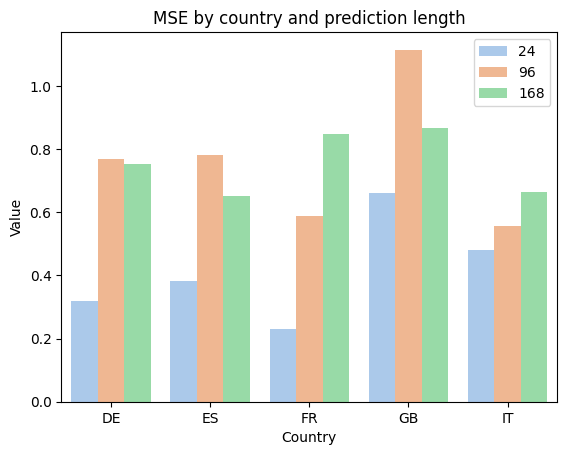

In [102]:
import seaborn as sns
import pandas as pd
df_mse = df[df['Metric'] == 'MSE']
# Create a bar plot with two datasets
#sns.barplot(x=['Country', 'Pred_len'], y='Value', hue='Metric', data=df, palette="pastel")
sns.barplot(x='Country', y='Value', hue='Pred_len', data=df_mse, palette="pastel")
# Add a legend
plt.legend()

# Set the title
plt.title("MSE by country and prediction length")
plt.show()

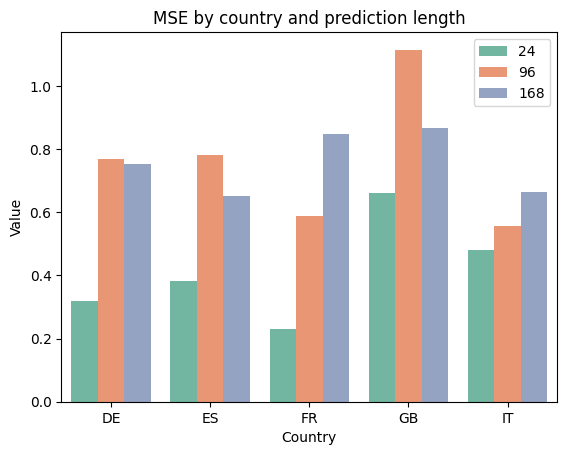

In [103]:
import seaborn as sns
import pandas as pd
df_mse = df[df['Metric'] == 'MSE']
# Create a bar plot with two datasets
#sns.barplot(x=['Country', 'Pred_len'], y='Value', hue='Metric', data=df, palette="pastel")
sns.barplot(x='Country', y='Value', hue='Pred_len', data=df_mse, palette="Set2")
# Add a legend
plt.legend()

# Set the title
plt.title("MSE by country and prediction length")
plt.show()

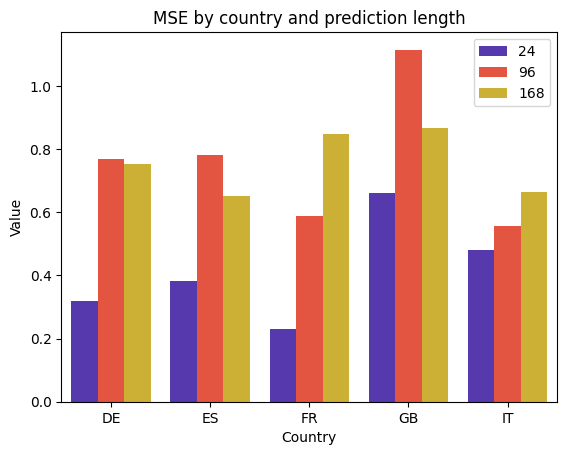

In [106]:
import seaborn as sns
import pandas as pd
df_mse = df[df['Metric'] == 'MSE']
# Create a bar plot with two datasets
#sns.barplot(x=['Country', 'Pred_len'], y='Value', hue='Metric', data=df, palette="pastel")
sns.barplot(x='Country', y='Value', hue='Pred_len', data=df_mse, palette="CMRmap")
# Add a legend
plt.legend()

# Set the title
plt.title("MSE by country and prediction length")
plt.show()

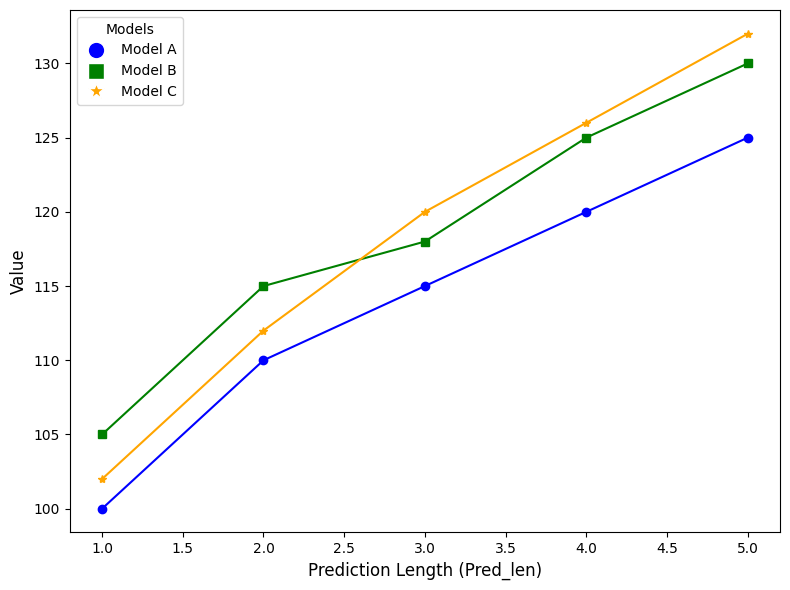

In [125]:
import matplotlib.pyplot as plt

# Example data
models = ['Model A', 'Model B', 'Model C']
pred_len = [1, 2, 3, 4, 5]  # x-axis: Prediction lengths
values = {
    'Model A': [100, 110, 115, 120, 125],  # y-axis values for Model A
    'Model B': [105, 115, 118, 125, 130],  # y-axis values for Model B
    'Model C': [102, 112, 120, 126, 132]   # y-axis values for Model C
}

# Define different markers and line styles
markers = ['o', 's', '*']  #'^' Circle, Square, Star markers
colors = ['blue', 'green', 'orange']  # Different colors for each model

fig, ax = plt.subplots(figsize=(8, 6))

# Plot each model with its line and marker
for idx, model in enumerate(models):
    ax.plot(pred_len, values[model], marker=markers[idx], color=colors[idx], label=model, linestyle='-')

# Customize legend to only show model names and corresponding markers
legend_elements = [plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors[i], markersize=12, label=models[i]) 
                   for i in range(len(models))]

# Add the legend to the plot
ax.legend(handles=legend_elements, title="Models", loc="best")

# Add axis labels
ax.set_xlabel('Prediction Length (Pred_len)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [132]:
df_persistence_country.columns

MultiIndex([('Persistence',  'MSE'),
            ('Persistence',  'MAE'),
            ('Persistence', 'RMSE')],
           names=['Model', 'Metrics'])

In [133]:
df_persistence_country.loc[('DE'), ('Persistence', 'MSE')]
#arima_df_countr

Pred_len
24     0.69368
96     0.98462
168    0.85048
Name: (Persistence, MSE), dtype: float64

In [134]:
from matplotlib.plot_color_gradients import plot_color_gradients
plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

NameError: name 'plot_color_gradients' is not defined

    Pred_len  Value    Model
0          1    100  Model A
1          2    110  Model A
2          3    115  Model A
3          4    120  Model A
4          5    125  Model A
5          1    105  Model B
6          2    115  Model B
7          3    118  Model B
8          4    125  Model B
9          5    130  Model B
10         1    102  Model C
11         2    112  Model C
12         3    120  Model C
13         4    126  Model C
14         5    132  Model C


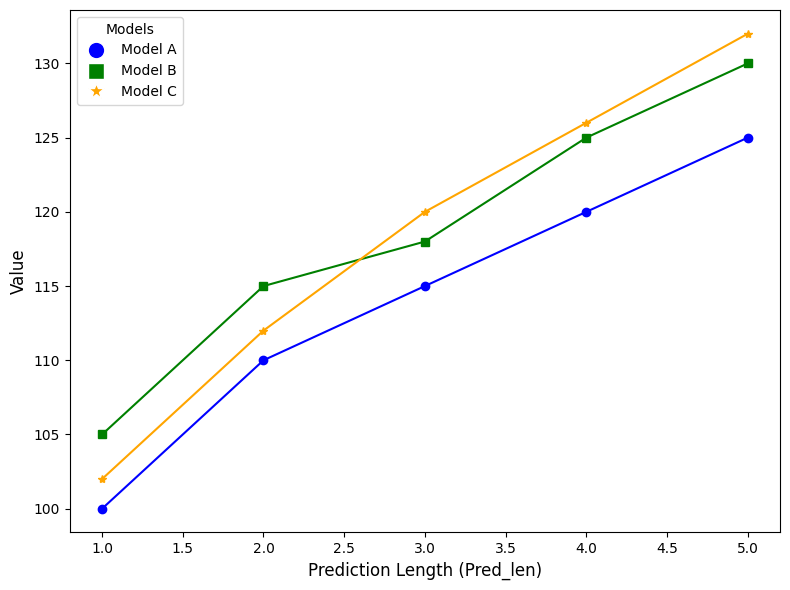

In [126]:
import matplotlib.pyplot as plt
import pandas as pd

models = ['Persistense', '(S)ARIMA']

# Create DataFrame
df = pd.DataFrame(data)

# Show the DataFrame
print(df)

# Define markers and colors for each model
models = ['Persistense', '(S)ARIMA', 'Informer', 'PatchTST']
markers = ['o', 's', '*', '^'] # , 'X'
colors = ['blue', 'green', 'orange', 'red'] # 'purple'

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each model with its line and marker
for idx, model in enumerate(models):
    subset = df[df['Model'] == model]
    ax.plot(subset['Pred_len'], subset['Value'], marker=markers[idx], color=colors[idx], label=model, linestyle='-')

# Customize legend to only show model names and corresponding markers
legend_elements = [plt.Line2D([0], [0], marker=markers[idx], color='w', markerfacecolor=colors[idx], markersize=12, label=model)
                   for model in markers]

# Add the legend to the plot
ax.legend(handles=legend_elements, title="Models", loc="best")

# Add axis labels
ax.set_xlabel('Prediction Length (Pred_len)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
